In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_dir = '/content/drive/MyDrive/Colab Notebooks/GAN'

In [ ]:
%cd $main_dir
!ls

/content/drive/MyDrive/Colab Notebooks/GAN
saved_models   wGAN_gradient_clipping
saved_results  wGAN_gradient_penalty.ipynb


In [ ]:
from pathlib import Path

experiment_name = "mnist_one_to_three"
method = "wgan"

this_dir = Path.cwd()
model_dir = this_dir / "saved_models" / experiment_name / method
output_dir = this_dir / "saved_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [ ]:
from time import time, localtime

def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d

### **Load data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data

In [ ]:
(train_set, label_set), (test_set, test_label) = load_data()

In [ ]:
print(train_set.shape)
print(label_set.shape)

(60000, 28, 28)
(60000,)


In [ ]:
def plot_img(x, sample=20):
  x = (x + 1)/2.0
  plt.figure()
  for i in range(sample):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(x[i], cmap='gray_r')
  plt.show()

In [ ]:
def data_processing(x):
  x = (x - 127.5)/127.5
  x = np.expand_dims(x, axis=-1)
  x = x.astype('float32')
  return x

In [ ]:
x_train = data_processing(train_set)
idx = np.where(label_set.flatten() <= 3)
x_train = x_train[idx]

In [ ]:
x_test = data_processing(test_set)
idx = np.where(test_label.flatten() <= 3)
x_test = x_test[idx]

In [ ]:
print(x_train.shape)
print(x_test.shape)

(24754, 28, 28, 1)
(4157, 28, 28, 1)


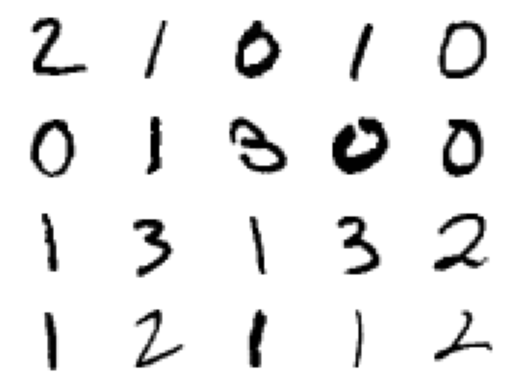

In [ ]:
plot_img(x_test)

# **Create Model**

In [ ]:
# Khởi thạo tham số và mô hình

epochs = 20
learning_rate=0.0002
BATCH_SIZE=64
n_critic=3
latent_dim=256

In [ ]:
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Dropout, ZeroPadding2D, InputLayer, Cropping2D

### **Classifier**

In [ ]:
def _classifier(input_shape=(28,28,1)):
  model = Sequential()

  model.add(InputLayer(input_shape=input_shape))
  model.add(ZeroPadding2D((2,2)))

  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
classifier = _classifier()
classifier.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9), metrics=['acc'])
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_2 (ZeroPaddi  (None, 32, 32, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        1088      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                      

### **Critic**

In [ ]:
def _critic(input_shape=(28,28,1)):
  model = Sequential()

  model.add(InputLayer(input_shape=input_shape))
  model.add(ZeroPadding2D((2,2)))

  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(256, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1))

  return model

In [ ]:
critic = _critic()
critic.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_3 (ZeroPaddi  (None, 32, 32, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        1088      
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)       

### **Generator**

In [ ]:
def _generator(latent_dim):
  n_dims = 4 * 4 * 256
  model = Sequential()

  model.add(Dense(n_dims, input_shape=(latent_dim,)))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((4, 4, 256)))

  model.add(Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2DTranspose(64, (4,4), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2DTranspose(32, (4,4), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, (7,7), strides=(1,1), padding='same', activation='tanh'))
  model.add(Cropping2D((2,2)))

  return model

In [ ]:
generator = _generator(latent_dim)
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4096)              1052672   
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 8, 8, 128)        

## **WGAN Model**

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam

### **WGAN**

In [ ]:
class WGAN(Model):
    def __init__(
        self,
        discriminator,
        generator,
        classifier,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.classifier = classifier
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, c_optimizer, d_loss_fn, g_loss_fn, c_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.c_loss_fn = c_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """
        Tính toán phạt cho gradient
        hàm loss này được tính toán trên ảnh interpolated và được thêm vào discriminator loss
        """
        # tạo interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. dự đoán discriminator output cho interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Tính gradients cho interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Tính norm của gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]

        # Với mỗi một batch chúng ta sẽ thực hiện những bước sau
        # following steps as laid out in the original paper.
        # 1. Lấy mẫu ngẫu nhiên ảnh real và ảnh fake. Trong đó ảnh real được lựa chọn từ mô hình và ảnh fake được tạo ra từ generator từ một véc tơ ngẫu nhiên.
        # 2. Tính toán phạt cho gradient dựa trên chênh lệch giữa ảnh real và ảnh fake. Gradient được lấy trong bối cảnh của hàm `tf.GradientTape()`.
        # 3. Nhân phạt của gradient với một giá trị hệ số alpha.
        # 4. Tính loss function cho discirminator
        # 5. Thêm phạt gradient vào loss function của discriminator
        # 6. Cập nhật gradient theo loss function của discriminator và generator thông qua hàm `tape.apply_gradients()`
        # Chúng ta sẽ huấn luyện discrimnator với d_steps trước. và sau đó chúng ta mới huấn luyện generator.
        # Như vậy cùng một batch thì discriminator được huấn luyện gấp d_steps lần so với generator.

        # Huấn luyện critic
        for i in range(self.d_steps):
            # Khởi tạo latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            # Chúng ta phải thực thi trong tf.GradientTap() để lấy được giá trị gradient.
            with tf.GradientTape() as tape:
                # Tạo ảnh fake từ latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Dự báo điểm cho ảnh fake
                fake_logits = self.discriminator(fake_images, training=True)
                # Dự báo điểm cho ảnh real
                real_logits = self.discriminator(real_images, training=True)

                # Tính discriminator loss từ ảnh real và ảnh fake
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Tính phạt gradient
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Thêm phạt gradient cho discriminator loss ban đầu
                d_loss = d_cost + gp * self.gp_weight

            # Lấy gradient của discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)

            # Cập nhật weights của discriminator sử dụng discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Huấn luyện classifier
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape_f:
            fake_samples = self.generator(random_latent_vectors, training=True)
            y_pred_f = self.classifier(fake_samples, training=True)
            y_true_f = tf.zeros(shape=(batch_size, 1))
            c_loss_f = self.c_loss_fn(y_true_f, y_pred_f)
        cf_gradient = tape_f.gradient(c_loss_f, self.classifier.trainable_variables)
        self.c_optimizer.apply_gradients(
            zip(cf_gradient, self.classifier.trainable_variables)
        )

        with tf.GradientTape() as tape_r:
            y_pred_r = self.classifier(real_images, training=True)
            y_true_r = tf.ones(shape=(batch_size, 1))
            c_loss_r = self.c_loss_fn(y_true_r, y_pred_r)
        cr_gradient = tape_r.gradient(c_loss_r, self.classifier.trainable_variables)
        self.c_optimizer.apply_gradients(
            zip(cr_gradient, self.classifier.trainable_variables)
        )

        # Huấn luyện generator
        # Khởi tạo véc tơ latent
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Tạo ảnh fake từ generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            # Dự báo điểm cho ảnh fake từ discriminator
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Tính generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Lấy gradient cho generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Cập nhật hệ số của generator sử dụng generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss, "c_loss_r": c_loss_r, "c_loss_f": c_loss_f}

### **Callback**

In [ ]:
class GANMonitor(Callback):
    def __init__(self, num_img=20, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors, training=True)
        plot_img(generated_images)

### **Training**

In [ ]:
# Khởi tạo optimizer
# learning_rate=0.0002, beta_1=0.5 được khuyến nghị
generator_optimizer = Adam(
    learning_rate=learning_rate, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=learning_rate, beta_1=0.5, beta_2=0.9
)
classifier_optimizer = Adam(
    learning_rate=learning_rate, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function

# Xác định loss functions được sử dụng cho discriminator = (fake_loss - real_loss).
# Ở hàm train_step của WGAN chúng ta phải thêm phạt gradient penalty cho hàm này.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Xác định loss function cho generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Xác định loss function cho classifier.
def classifier_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred)

# Callbacks
cbk = GANMonitor(num_img=20, latent_dim=latent_dim)

# wgan model
wgan = WGAN(
    discriminator=critic,
    generator=generator,
    classifier=classifier,
    latent_dim=latent_dim,
    discriminator_extra_steps=n_critic,
)

# Compile model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    c_optimizer=classifier_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    c_loss_fn=classifier_loss,
)

Epoch 1/20
387/387 [==============================] - ETA: 0s - d_loss: -3531.0593 - g_loss: 840.6150 - c_loss_r: 0.6460 - c_loss_f: 0.6961

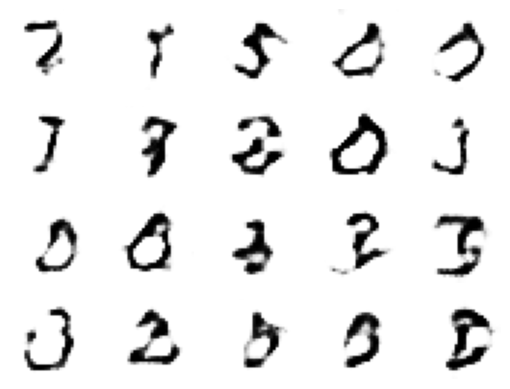

387/387 [==============================] - 49s 94ms/step - d_loss: -3541.9038 - g_loss: 844.7276 - c_loss_r: 0.6460 - c_loss_f: 0.6961
Epoch 2/20
387/387 [==============================] - ETA: 0s - d_loss: -15420.9156 - g_loss: 4059.7716 - c_loss_r: 0.6494 - c_loss_f: 0.6434

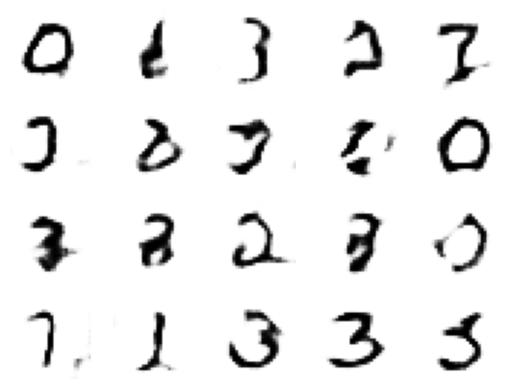

387/387 [==============================] - 37s 96ms/step - d_loss: -15450.9879 - g_loss: 4073.2900 - c_loss_r: 0.6494 - c_loss_f: 0.6434
Epoch 3/20
387/387 [==============================] - ETA: 0s - d_loss: -21382.0076 - g_loss: 5096.4513 - c_loss_r: 0.6131 - c_loss_f: 0.6070

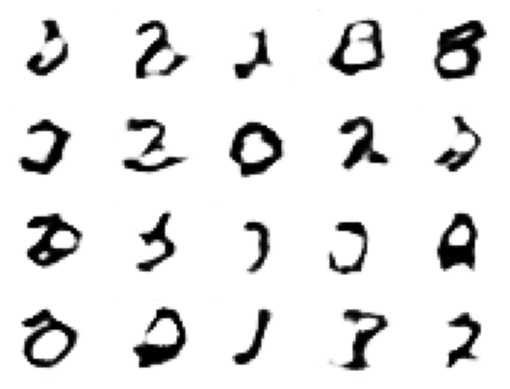

387/387 [==============================] - 38s 98ms/step - d_loss: -21345.6431 - g_loss: 5069.5996 - c_loss_r: 0.6130 - c_loss_f: 0.6070
Epoch 4/20
387/387 [==============================] - ETA: 0s - d_loss: -33229.7684 - g_loss: 9849.1483 - c_loss_r: 0.5900 - c_loss_f: 0.5833

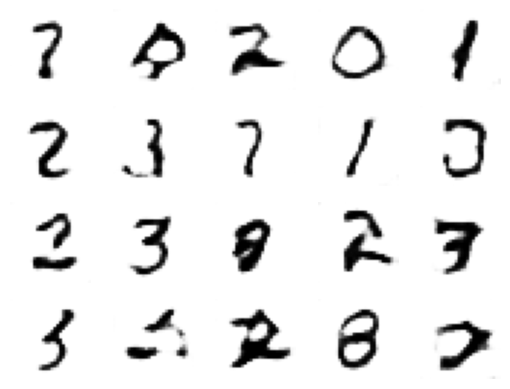

387/387 [==============================] - 38s 98ms/step - d_loss: -33140.2024 - g_loss: 9875.7525 - c_loss_r: 0.5900 - c_loss_f: 0.5832
Epoch 5/20
387/387 [==============================] - ETA: 0s - d_loss: -50290.7134 - g_loss: 14783.3455 - c_loss_r: 0.5686 - c_loss_f: 0.5644

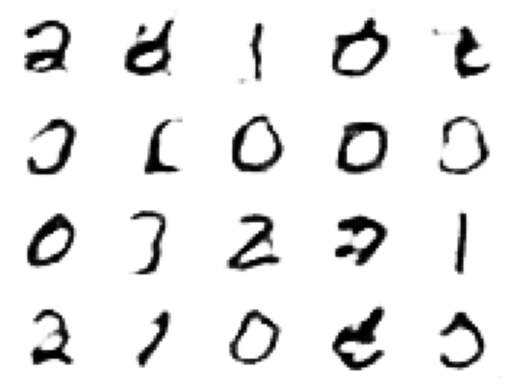

387/387 [==============================] - 38s 98ms/step - d_loss: -50258.4485 - g_loss: 14826.3787 - c_loss_r: 0.5689 - c_loss_f: 0.5645
Epoch 6/20
387/387 [==============================] - ETA: 0s - d_loss: -66605.1974 - g_loss: 21219.8653 - c_loss_r: 0.5560 - c_loss_f: 0.5543

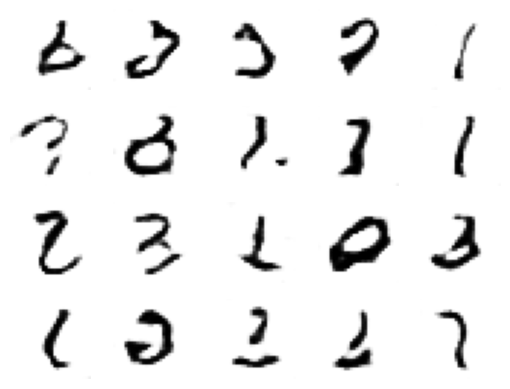

387/387 [==============================] - 38s 99ms/step - d_loss: -66741.9295 - g_loss: 21277.9979 - c_loss_r: 0.5559 - c_loss_f: 0.5541
Epoch 7/20
387/387 [==============================] - ETA: 0s - d_loss: -86541.2960 - g_loss: 29376.3136 - c_loss_r: 0.5549 - c_loss_f: 0.5454

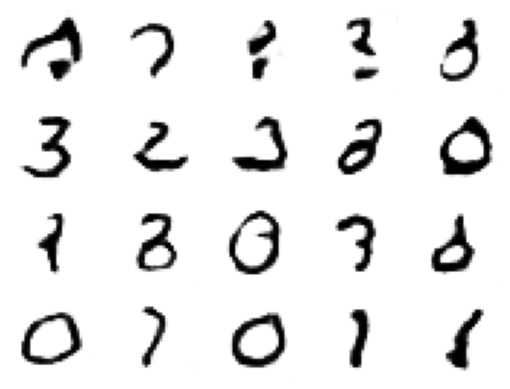

387/387 [==============================] - 39s 101ms/step - d_loss: -86561.6587 - g_loss: 29346.1022 - c_loss_r: 0.5550 - c_loss_f: 0.5453
Epoch 8/20
387/387 [==============================] - ETA: 0s - d_loss: -87578.9222 - g_loss: 31345.1460 - c_loss_r: 0.5496 - c_loss_f: 0.5439

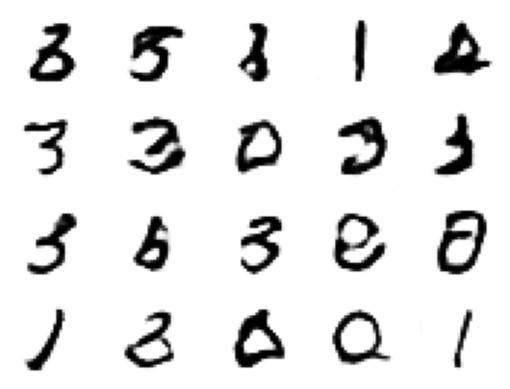

387/387 [==============================] - 39s 100ms/step - d_loss: -87623.3794 - g_loss: 31253.1189 - c_loss_r: 0.5495 - c_loss_f: 0.5440
Epoch 9/20
387/387 [==============================] - ETA: 0s - d_loss: -106635.9540 - g_loss: 35277.0299 - c_loss_r: 0.5503 - c_loss_f: 0.5472

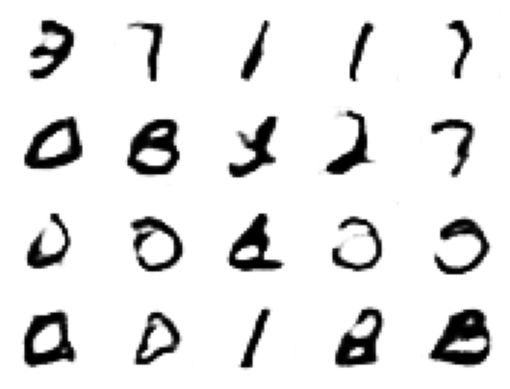

387/387 [==============================] - 39s 100ms/step - d_loss: -106355.6698 - g_loss: 35395.8088 - c_loss_r: 0.5502 - c_loss_f: 0.5475
Epoch 10/20
387/387 [==============================] - ETA: 0s - d_loss: -127427.3932 - g_loss: 49744.8513 - c_loss_r: 0.5468 - c_loss_f: 0.5467

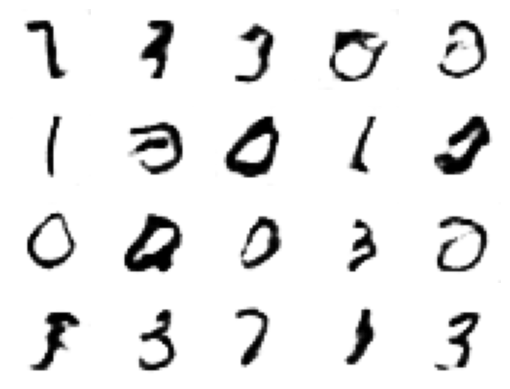

387/387 [==============================] - 39s 101ms/step - d_loss: -127641.4075 - g_loss: 49839.6931 - c_loss_r: 0.5466 - c_loss_f: 0.5468
Epoch 11/20
387/387 [==============================] - ETA: 0s - d_loss: -129407.0298 - g_loss: 52143.5903 - c_loss_r: 0.5539 - c_loss_f: 0.5526

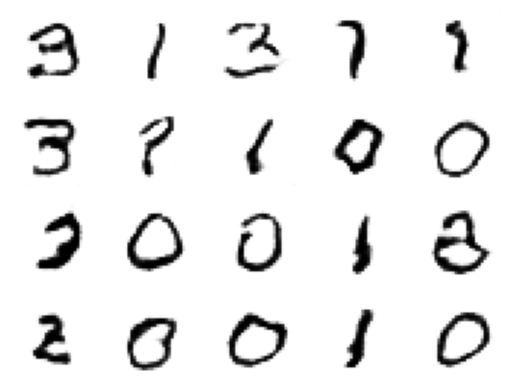

387/387 [==============================] - 39s 102ms/step - d_loss: -129851.4807 - g_loss: 52352.6866 - c_loss_r: 0.5540 - c_loss_f: 0.5530
Epoch 12/20
387/387 [==============================] - ETA: 0s - d_loss: -152897.3306 - g_loss: 61151.0209 - c_loss_r: 0.5507 - c_loss_f: 0.5519

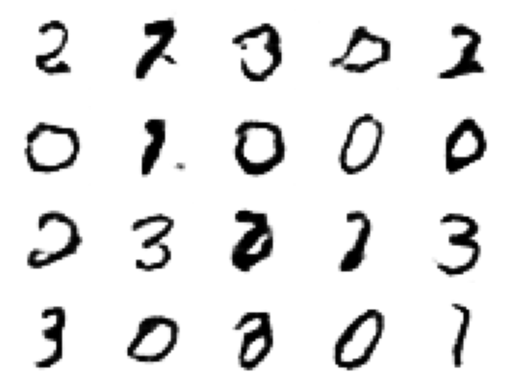

387/387 [==============================] - 39s 101ms/step - d_loss: -153086.8003 - g_loss: 60880.8862 - c_loss_r: 0.5506 - c_loss_f: 0.5517
Epoch 13/20
387/387 [==============================] - ETA: 0s - d_loss: -151041.8800 - g_loss: 59584.2461 - c_loss_r: 0.5505 - c_loss_f: 0.5512

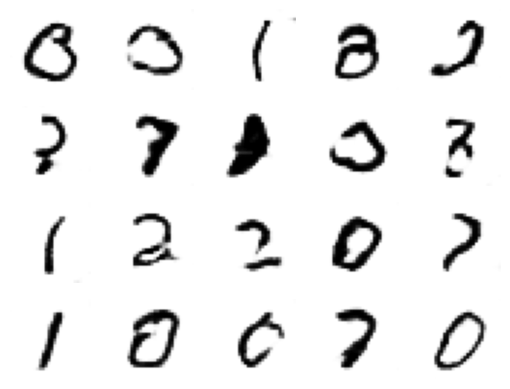

387/387 [==============================] - 39s 101ms/step - d_loss: -151052.0073 - g_loss: 59614.4829 - c_loss_r: 0.5506 - c_loss_f: 0.5512
Epoch 14/20
387/387 [==============================] - ETA: 0s - d_loss: -170762.5262 - g_loss: 71212.9477 - c_loss_r: 0.5561 - c_loss_f: 0.5548

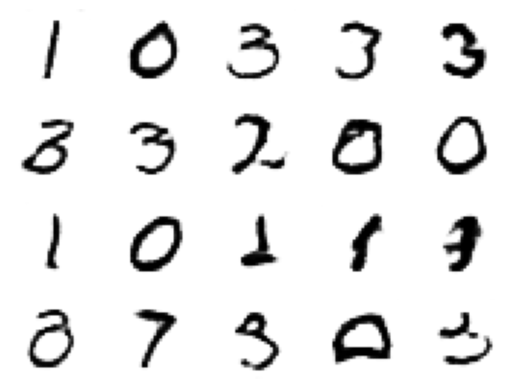

387/387 [==============================] - 39s 102ms/step - d_loss: -170928.9557 - g_loss: 71108.2711 - c_loss_r: 0.5563 - c_loss_f: 0.5549
Epoch 15/20
387/387 [==============================] - ETA: 0s - d_loss: -174802.3788 - g_loss: 66116.0345 - c_loss_r: 0.5512 - c_loss_f: 0.5537

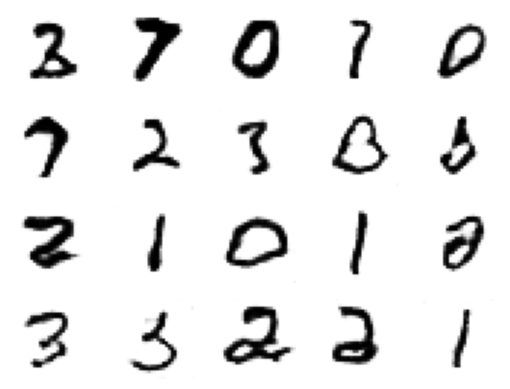

387/387 [==============================] - 39s 101ms/step - d_loss: -174913.2644 - g_loss: 66300.5317 - c_loss_r: 0.5512 - c_loss_f: 0.5537
Epoch 16/20
387/387 [==============================] - ETA: 0s - d_loss: -186522.3630 - g_loss: 61744.9243 - c_loss_r: 0.5507 - c_loss_f: 0.5523

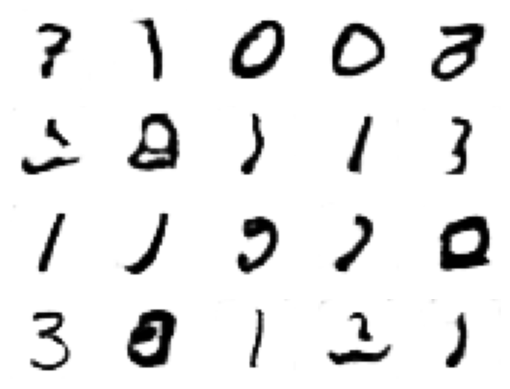

387/387 [==============================] - 39s 101ms/step - d_loss: -186565.3392 - g_loss: 61654.6300 - c_loss_r: 0.5506 - c_loss_f: 0.5523
Epoch 17/20
387/387 [==============================] - ETA: 0s - d_loss: -191560.4526 - g_loss: 66797.4694 - c_loss_r: 0.5541 - c_loss_f: 0.5551

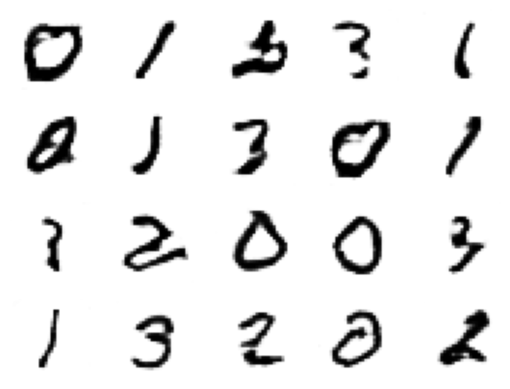

387/387 [==============================] - 39s 101ms/step - d_loss: -191220.8706 - g_loss: 66979.8596 - c_loss_r: 0.5542 - c_loss_f: 0.5551
Epoch 18/20
387/387 [==============================] - ETA: 0s - d_loss: -188149.5800 - g_loss: 61804.3233 - c_loss_r: 0.5578 - c_loss_f: 0.5589

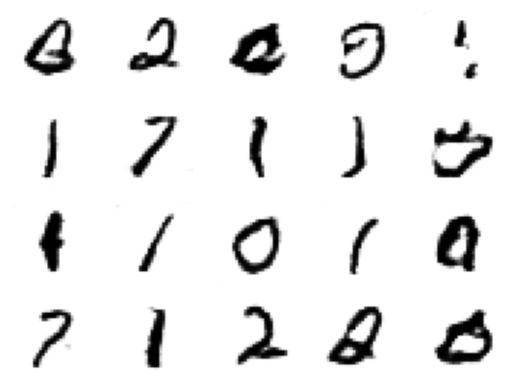

387/387 [==============================] - 39s 102ms/step - d_loss: -187877.7324 - g_loss: 62121.4895 - c_loss_r: 0.5579 - c_loss_f: 0.5588
Epoch 19/20
387/387 [==============================] - ETA: 0s - d_loss: -201645.0267 - g_loss: 70283.1573 - c_loss_r: 0.5551 - c_loss_f: 0.5580

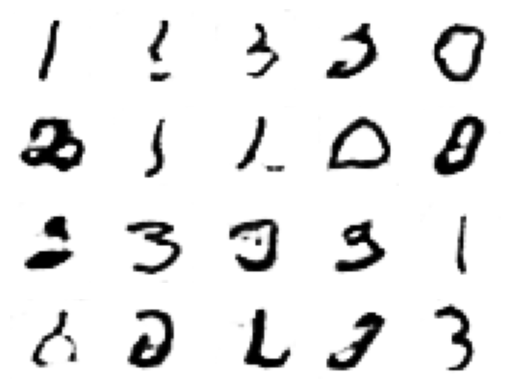

387/387 [==============================] - 39s 101ms/step - d_loss: -201944.3800 - g_loss: 70011.5797 - c_loss_r: 0.5549 - c_loss_f: 0.5579
Epoch 20/20
387/387 [==============================] - ETA: 0s - d_loss: -232204.1311 - g_loss: 77371.4091 - c_loss_r: 0.5582 - c_loss_f: 0.5635

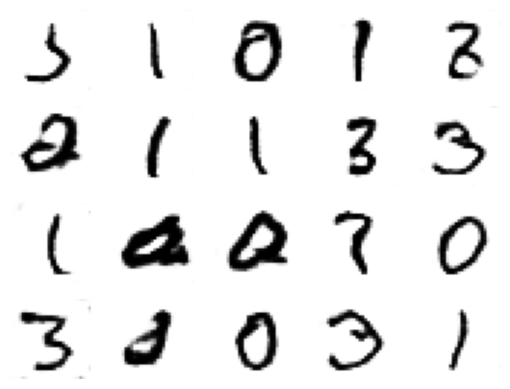

387/387 [==============================] - 39s 101ms/step - d_loss: -231437.7785 - g_loss: 77744.9806 - c_loss_r: 0.5582 - c_loss_f: 0.5637


In [ ]:
# Huấn luyện
start = time()
wgan.fit(x_train, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
end = time()
duration = end - start

In [ ]:
total_time = "Time: {}".format(sec_to_hours(duration))
print(total_time)

Time: 0 hours 13 mins 6 seconds


# **Evaluate**

In [ ]:
classifier_file = str(model_dir) + '/classifier_model.h5'
generator_file = str(model_dir) + '/generator_model.h5'

In [ ]:
def generate_known_sample(datasets):
  know_sample = datasets
  know_label = np.ones(shape=(know_sample.shape[0], 1))
  return know_sample, know_label

In [ ]:
def generate_unknown_sample(x_test, y_test):
  unknow_sample = data_processing(x_test)
  idx = np.where(y_test.flatten() >= 7)
  unknow_sample = unknow_sample[idx]
  unknow_label = np.zeros(shape=(unknow_sample.shape[0], 1))
  return unknow_sample, unknow_label

In [ ]:
know_sample, know_label = generate_known_sample(x_train)
unknow_sample, unknow_label = generate_unknown_sample(test_set, test_label)

In [ ]:
x_test = np.concatenate((know_sample, unknow_sample), axis=0)
y_test = np.concatenate((know_label, unknow_label), axis=0)

In [ ]:
print(x_test.shape, y_test.shape)

(27765, 28, 28, 1) (27765, 1)


In [ ]:
# Shuffle
idx = np.random.permutation(x_test.shape[0])
x_test = x_test[idx]
y_test = y_test[idx]

In [ ]:
classifier.save(classifier_file)
generator.save(generator_file)

In [ ]:
def summarize_performance(generator, latent_dim, sample=20):
  noise = tf.random.normal(shape=(sample, latent_dim))
  x = generator.predict(noise)
  plot_img(x, sample)

1/1 [==============================] - 0s 21ms/step


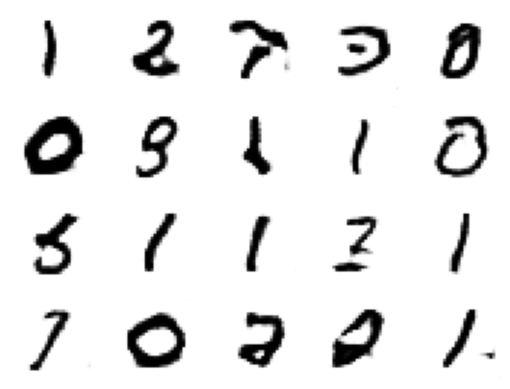

In [ ]:
summarize_performance(generator, latent_dim)

In [ ]:
loss, acc = classifier.evaluate(x_test, y_test)

868/868 [==============================] - 3s 3ms/step - loss: 0.5233 - acc: 0.7860


In [ ]:
predictions = classifier.predict(x_test, verbose=2, use_multiprocessing=True, batch_size=BATCH_SIZE)

434/434 - 1s - 1s/epoch - 2ms/step


In [ ]:
print(predictions.shape)

(27765, 1)


In [ ]:
tmp = np.where(predictions >= 0.5, 1, 0)
print(tmp.shape)

(27765, 1)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(y_test, tmp)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(y_test, tmp)), file=f)

    print('Micro Precision: {:.2f}\n'.format(
        precision_score(y_test, tmp, average='micro')), file=f)
    print('Micro Recall: {:.2f}\n'.format(
        recall_score(y_test, tmp, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, tmp, average='micro')), file=f)

    print('Macro Precision: {:.2f}\n'.format(
        precision_score(y_test, tmp, average='macro')), file=f)
    print('Macro Recall: {:.2f}\n'.format(
        recall_score(y_test, tmp, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, tmp, average='macro')), file=f)

    print('Weighted Precision: {:.2f}\n'.format(
        precision_score(y_test, tmp, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}\n'.format(
        recall_score(y_test, tmp, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}\n'.format(f1_score(y_test, tmp, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(y_test, tmp), file=f)
    f.close()